In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from influxdb import DataFrameClient
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

## Useful functions

In [21]:
def to_celsius(temp_fahrenheit: float):
    """Converts temperature from F to C."""

    temp_celsius = (temp_fahrenheit-32)*5/9

    # data check to catch measurement errors
    if temp_celsius > 60:
        raise ValueError("Too warm. We are going to burn!")
    elif temp_celsius < -90: 
        raise ValueError("It's too cold, double check this data!")
    else:
        return temp_celsius


def extract_row_values(row: str) -> list:
    """
    Extracting records data from ther initial row from .op file. 
    """
    stn  = str(row[:6])
    wban = int(row[7:12]) 
    date = datetime.strptime(row[14:22], "%Y%m%d")
    mean = float(row[24:30])
    max  = float(row[102:108])
    min  = float(row[110:116])
    
    return [date, stn, wban, mean, max, min]


def init_influxdb_df_client(host: str,
                            port: int,
                            username: str,
                            password: str,
                            db: str) -> DataFrameClient:
    """
    Initialization of the InfluxDB client
    """
    influxdb_client = DataFrameClient(host=host,
                                      port=port,
                                      username=username,
                                      password=password)
    influxdb_client.switch_database(db)
    return influxdb_client

## Dataflow example

In [146]:
# initializing influx db client
db=""
influxdb_client = init_influxdb_df_client(host="", port="", username="", password="", db=db)


In [11]:
# reading example file
file_path = "../data/example-data.op"

with open(file_path) as f:
        data = f.readlines()

In [12]:
# let's process everything except header 
processed_data = []
for row in data[1:]:
    processed_data.append(extract_row_values(row))

# printing few examples
processed_data[:5]

[[datetime.datetime(1980, 1, 1, 0, 0), '125700', 99999, 29.2, 46.4, 17.6],
 [datetime.datetime(1980, 1, 2, 0, 0), '125700', 99999, 26.1, 30.2, 23.0],
 [datetime.datetime(1980, 1, 3, 0, 0), '125700', 99999, 24.4, 26.6, 21.2],
 [datetime.datetime(1980, 1, 4, 0, 0), '125700', 99999, 19.7, 21.2, 17.6],
 [datetime.datetime(1980, 1, 5, 0, 0), '125700', 99999, 17.8, 24.8, 14.0]]

In [13]:
# specifying header columns
columns = ["date", "stn", "wban", "mean", "max", "min"]

# let's put this into dataframe
processed_data_df = pd.DataFrame(processed_data, columns=columns)
processed_data_df.head()

,date,stn,wban,mean,max,min
0,1980-01-01,125700,99999,29.2,46.4,17.6
1,1980-01-02,125700,99999,26.1,30.2,23.0
2,1980-01-03,125700,99999,24.4,26.6,21.2
3,1980-01-04,125700,99999,19.7,21.2,17.6
4,1980-01-05,125700,99999,17.8,24.8,14.0


In [14]:
# substite missing values
processed_data_df = processed_data_df.replace(["999999", 99999, 9999.9], np.nan)
processed_data_df.head()


,date,stn,wban,mean,max,min
0,1980-01-01,125700,NaN,29.2,46.4,17.6
1,1980-01-02,125700,NaN,26.1,30.2,23.0
2,1980-01-03,125700,NaN,24.4,26.6,21.2
3,1980-01-04,125700,NaN,19.7,21.2,17.6
4,1980-01-05,125700,NaN,17.8,24.8,14.0


In [15]:
# let's check info of the dataframe to spot nan values
processed_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    366 non-null    datetime64[ns]
 1   stn     366 non-null    object        
 2   wban    0 non-null      float64       
 3   mean    366 non-null    float64       
 4   max     366 non-null    float64       
 5   min     366 non-null    float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 17.3+ KB


In [16]:
# convert Fahrenheit to Celsius
processed_data_df["mean"] = processed_data_df["mean"].apply(to_celsius)
processed_data_df["max"]  = processed_data_df["max"].apply(to_celsius)
processed_data_df["min"]  = processed_data_df["min"].apply(to_celsius)

processed_data_df.head()

,date,stn,wban,mean,max,min
0,1980-01-01,125700,NaN,-1.555556,8.0,-8.0
1,1980-01-02,125700,NaN,-3.277778,-1.0,-5.0
2,1980-01-03,125700,NaN,-4.222222,-3.0,-6.0
3,1980-01-04,125700,NaN,-6.833333,-6.0,-8.0
4,1980-01-05,125700,NaN,-7.888889,-4.0,-10.0


In [17]:
# generate unique station id
wban = processed_data_df.wban.values[0]
stn  = processed_data_df.stn.values[0]
stid = str(stn) + str(wban)

print(f"unique station id is {stid}")

unique station id is 125700nan


In [18]:
# reading processed metadata file
metadata = pd.read_csv("../data/metadata.csv")

# adding metadata to the measurement
station_metadata = metadata[metadata.stid == stid]
station_metadata.head()

,ctry,station_name,stid
4040,PL,KIELCE-SUKOW,125700nan


In [19]:
# data check: if match is not found with metadata we discard measurement
if len(station_metadata) > 0:
    processed_data_df["ctry"] = station_metadata["ctry"].values[0]
    processed_data_df["station_name"] = station_metadata["station_name"].values[0]
    processed_data_df["stid"] = stid

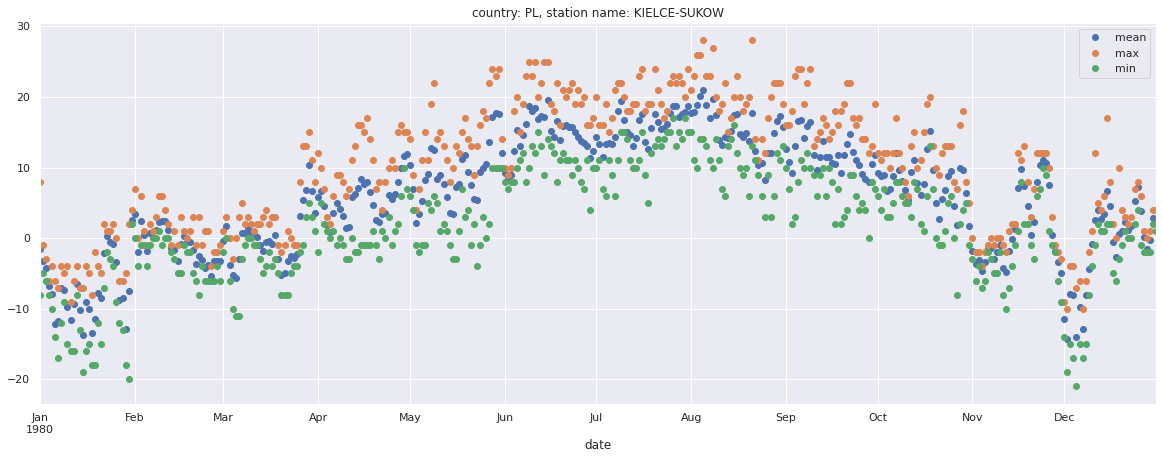

In [20]:
processed_data_df.set_index("date") \
                 .sort_index()[["mean", "max", "min"]] \
                 .plot(linestyle="",
                       figsize=(20, 7),
                       marker="o",
                       title="country: PL, station name: KIELCE-SUKOW")
plt.show()

In [158]:
# loading to the influxdb
influxdb_client.write_points(processed_data_df.set_index("date"), 
                             measurement="temperature",
                             tag_columns=["ctry", "station_name", "stid"],
                             database=db,
                             time_precision="ms",
                             field_columns=["mean", "max", "min"],
                             batch_size=100)


True